# 0.0. Understanding the problem

--Goal:
    
    --1.0 Predict the first destination that the new user will choose
    
    --Why?
        --What is the business model of Airbnb?
            --Marketplace (connect people who offer acomodation to whom are seeking a place)
            --Offer
                --Portfolio size
                --Portfolio diversity and density
                --Average price
                
            --Demand
                --Number of users
                --LTV (lifetime value)
                --CAC (client acquisition cost)
                
                Gross Revenue = (Fee*Number of clients) - CAC
                
--Solution:
    
    --Predictive model for the first destination of new user
    --1.0 Prediction save in a database
    --2.0 API
        --Input: User and features
        --Output: User and feature with destination prediction
        

# Module 1

## 0.0. Imports

In [57]:
#!pip install keras
#!pip install tensorflow
#!pip install scikit-plot

import random
import pickle
import seaborn as sns
import numpy   as np
import pandas  as pd
 
from sklearn    import metrics         as m
from sklearn    import model_selection as ms
from sklearn    import preprocessing   as pp
from scikitplot import metrics         as mt
from scipy      import stats           as ss
from datetime   import datetime        as dt

from keras import models as ml
from keras import layers as l

### 0.1. Helper Functions

In [27]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

### 0.2. Loading Data

In [28]:
df_raw = pd.read_csv('dataset/train_users_2.csv', low_memory=True)
df_raw.shape

(213451, 16)

In [29]:
df_sessions = pd.read_csv('dataset/sessions.csv', low_memory=True)
df_sessions.shape

(10567737, 6)

# 1.0. Data Description

In [30]:
df1 = df_raw.copy()

## 1.1. Data Dimensions

In [31]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 213451
Number of columns: 16


In [32]:
print('Number of rows: {}'.format(df_sessions.shape[0]))
print('Number of columns: {}'.format(df_sessions.shape[1]))

Number of rows: 10567737
Number of columns: 6


## 1.2. Data Type

In [33]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [34]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3. NA Check

In [35]:
df1.isna().sum()/len(df1)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [36]:
df_sessions.isna().sum()/len(df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

In [37]:
#date_first_booking
date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)


# ========== User =================
# age
df1 = df1[( df1['age'] > 15 ) & ( df1['age'] < 120 )]
avg_age = df1['age'].mean()
df1['age'] = df1['age'].fillna( avg_age )

#first_affiliate_tracked
df1 = df1[~df1['first_affiliate_tracked'].isna()]


# ========== Sessions =================
#user_id
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

#action
df_sessions = df_sessions[~df_sessions['action'].isna()]

#action_type
df_sessions = df_sessions[~df_sessions['action_type'].isna()]

#action_detail
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

#secs_elapsed
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

## 1.4. Change Data Type

In [38]:
 df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [39]:
#date_account_created
df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

#timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format='%Y%m%d%H%M%S')

#date_first_booking
df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

#age
df1['age'] = df1['age'].astype(int)

## 1.5. Check Balanced Data

In [40]:
df1['country_destination'].value_counts(normalize=True)

NDF      0.447275
US       0.391867
other    0.061246
FR       0.029918
IT       0.016423
GB       0.014335
ES       0.013740
CA       0.008676
DE       0.006858
NL       0.004852
AU       0.003531
PT       0.001280
Name: country_destination, dtype: float64

## 1.6. Descriptive Analysis

In [104]:
#Users
num_attributes = df1.select_dtypes(include=['int64','float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]'])
time_attributes = df1.select_dtypes(include=['datetime64[ns]'])

#Sessions
num_attributes_sessions = df_sessions.select_dtypes(include=['int64','float64'])
cat_attributes_sessions = df_sessions.select_dtypes(exclude=['int64','float64','datetime64[ns]'])
time_attributes_sessions = df_sessions.select_dtypes(include=['datetime64[ns]'])

### 1.6.1 Numerical - Users

In [42]:
#Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concat
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604696,2.705871,5.928298


### 1.6.2 Numerical - Sessions

In [43]:
#Central Tendency - Mean, Median
ct1 = pd.DataFrame(num_attributes_sessions.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes_sessions.apply(np.median)).T

#Dispersions - Std, Min, Max, Range, Skew, Kurtosis
d1 = pd.DataFrame(num_attributes_sessions.apply(np.std)).T
d2 = pd.DataFrame(num_attributes_sessions.apply(min)).T
d3 = pd.DataFrame(num_attributes_sessions.apply(max)).T
d4 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.kurtosis())).T

#Concat
ct = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
ct.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
ct

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 1.6.3. Categorical - Users

In [105]:
cat_attributes.drop(['id','age'], axis=1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


### 1.6.4 - Categorical - Sessions

In [45]:
cat_attributes_sessions.drop('user_id', axis=1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [47]:
#list of attributes for Cramer's V correlation
cat_attributes_list = cat_attributes_sessions.drop('user_id', axis=1).columns.tolist()

corr_dict = {}
for i in range(len (cat_attributes_list)):
    corr_list = []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes_sessions[ref], cat_attributes_sessions[feat])
        
        # append a list
        corr_list.append(corr)
    
    # appende a correlation list for each ref attributs
    corr_dict[ref] = corr_list

<AxesSubplot:>

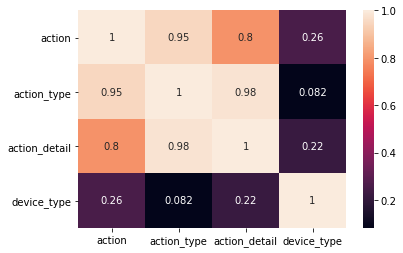

In [48]:
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True)

# 2.0. Feature Engineering

In [49]:
df2 = df1.copy()

## 2.1. Create New Features

In [125]:
#days from first active up to first booking
df2['first_active'] = pd.to_datetime(df2['timestamp_first_active'].dt.strftime( '%Y-%m-%d' ))
df2['days_from_frist_active_until_booking'] = (df2['date_first_booking'] - df2['first_active'] ).apply(lambda x: x.days)

#days from first active upt to account created
df2['days_from_first_active_until_account_created'] = (df2['date_account_created'] - df2['first_active']).apply(lambda x: x.days)

#days from account createad up to first booking
df2['days_from_account_created_until_first_booking'] = (df2['date_first_booking'] - df2['date_account_created']).apply(lambda x: x.days)


# ================== First Active ==================
#year first active
df2['year_first_active'] = df2['first_active'].dt.year

#month first active
df2['month_first_active'] = df2['first_active'].dt.month

#day first active
df2['day_first_active'] = df2['first_active'].dt.day

#day of week first active
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

#week of year first active
df2['week_of_year_first_active'] = df2['first_active'].dt.isocalendar().week
df2['week_of_year_first_active'] = np.asarray(df2['week_of_year_first_active']).astype(np.int64)


# ================== First Booking ==================
#year first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

#month first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

#day first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

#day of week first booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

#week of year first booking
df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.isocalendar().week
df2['week_of_year_first_booking'] = np.asarray(df2['week_of_year_first_booking']).astype(np.int64)


# ================== First Account Created =================
#year first booking
df2['year_account_created'] = df2['date_account_created'].dt.year

#month  account_created
df2['month_account_created'] = df2['date_account_created'].dt.month

#day  account_created
df2['day_account_created'] = df2['date_account_created'].dt.day

#day of week  account_created
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

#week of year  account_created
df2['week_of_year_account_created'] = df2['date_account_created'].dt.isocalendar().week
df2['week_of_year_account_created'] = np.asarray(df2['week_of_year_account_created']).astype(np.int64)

In [126]:
df2.dtypes

id                                                       object
date_account_created                             datetime64[ns]
timestamp_first_active                           datetime64[ns]
date_first_booking                               datetime64[ns]
gender                                                   object
age                                                       int32
signup_method                                            object
signup_flow                                               int64
language                                                 object
affiliate_channel                                        object
affiliate_provider                                       object
first_affiliate_tracked                                  object
signup_app                                               object
first_device_type                                        object
first_browser                                            object
country_destination                     

# 3.0. Data Filtering

In [127]:
df3 = df2.copy()

In [128]:
df2.head().T

,1,2,3,4,6
id,820tgsjxq7,4ft3gnwmtx,bjjt8pjhuk,87mebub9p4,lsw9q7uk0j
date_account_created,2011-05-25 00:00:00,2010-09-28 00:00:00,2011-12-05 00:00:00,2010-09-14 00:00:00,2010-01-02 00:00:00
timestamp_first_active,2009-05-23 17:48:09,2009-06-09 23:12:47,2009-10-31 06:01:29,2009-12-08 06:11:05,2010-01-02 01:25:58
date_first_booking,2015-06-29 00:00:00,2010-08-02 00:00:00,2012-09-08 00:00:00,2010-02-18 00:00:00,2010-01-05 00:00:00
gender,MALE,FEMALE,FEMALE,-unknown-,FEMALE
age,38,56,42,41,46
signup_method,facebook,basic,facebook,basic,basic
signup_flow,0,3,0,0,0
language,en,en,en,en,en
affiliate_channel,seo,direct,direct,direct,other


## 3.1. Filtering Rows

In [129]:
# Filtering rows:
# age - greater than 15 and lower than 120 - There are few people over 12O year old   
df3 = df3[( df3['age'] > 15 ) & ( df3['age'] < 120 )]

## 3.2. Columns Selection

# 4.0. Data Preparation

In [130]:
df4 = df3.copy()

In [131]:
#dummy variable
df4_dummy = pd.get_dummies(df4.drop(['id','country_destination'], axis=1))

#join id and country destination
df4 = pd.concat([df4[['id','country_destination']], df4_dummy], axis=1)

In [132]:
df4.shape

(122636, 144)

# 5.0. Feature Seleciotn

In [133]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking', 'first_active'] # original dates
df5 = df4.drop(cols_drop, axis=1)

In [134]:
X = df5.drop(['id', 'country_destination'], axis=1)
y = df5['country_destination'].copy()

In [135]:
#split dataset into train and test
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

# 6.0. Machine Learning

## 6.1. Baseline Model

In [136]:
country_destination_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
country_destination_weights = df1['country_destination'].value_counts(normalize=True).sort_index().tolist()

yhat_random = random.choices(population=country_destination_list, 
                             weights=country_destination_weights,
                             k=k_num)

### 6.1.1. Baseline Performance

Accuracy: 0.3602005870841487
Balanced Accuracy: 0.08299756180671218
Kappa Accuracy: 0.0004579450283984654
              precision    recall  f1-score   support

          AU       0.00      0.00      0.00        87
          CA       0.00      0.00      0.00       216
          DE       0.01      0.01      0.01       164
          ES       0.01      0.01      0.01       319
          FR       0.03      0.03      0.03       736
          GB       0.02      0.02      0.02       361
          IT       0.02      0.02      0.02       420
         NDF       0.45      0.45      0.45     10962
          NL       0.01      0.01      0.01       105
          PT       0.00      0.00      0.00        31
          US       0.39      0.40      0.39      9606
       other       0.05      0.05      0.05      1521

    accuracy                           0.36     24528
   macro avg       0.08      0.08      0.08     24528
weighted avg       0.36      0.36      0.36     24528



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

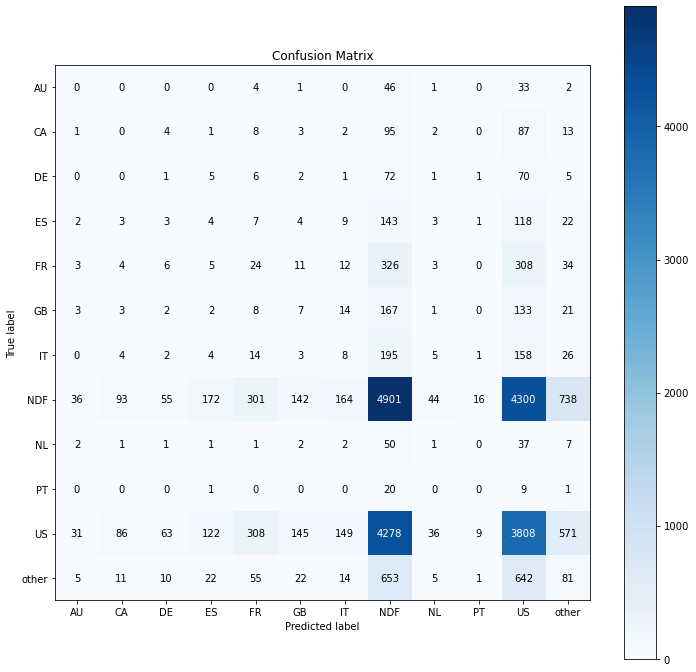

In [137]:
#accuracy
acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

#balanced accuracy
balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

#Kappa metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print('Kappa Accuracy: {}'.format(kappa_random))

#Classification report
print( m.classification_report( y_test, yhat_random ) )

#Confusion Matrix
mt.plot_confusion_matrix( y_test, yhat_random, normalize=False, figsize=(12,12))

## 6.2. Neural Network - MLP

In [138]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1, 1)).toarray()

In [139]:
X_train.shape

(98108, 138)

In [140]:
# model definition
model = ml.Sequential()
model.add(l.Dense(256, input_dim=X_train.shape[1], activation='relu'))
model.add(l.Dense(12, activation='softmax'))

# model compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
model.fit(X_train, y_train_nn, epochs=100)

Epoch 1/100
3066/3066 [==============================] - 9s 2ms/step - loss: 11.7014 - accuracy: 0.7176
Epoch 2/100
3066/3066 [==============================] - 5s 2ms/step - loss: 2.8775 - accuracy: 0.7452
Epoch 3/100
3066/3066 [==============================] - 5s 2ms/step - loss: 1.3723 - accuracy: 0.7739
Epoch 4/100
3066/3066 [==============================] - 5s 2ms/step - loss: 0.9320 - accuracy: 0.8043
Epoch 5/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.7377 - accuracy: 0.8254
Epoch 6/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.6770 - accuracy: 0.8370
Epoch 7/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.6484 - accuracy: 0.8388
Epoch 8/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.6422 - accuracy: 0.8388
Epoch 9/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.6366 - accuracy: 0.8406
Epoch 10/100
3066/3066 [==============================] - 4s 1ms/step - 

3066/3066 [==============================] - 4s 1ms/step - loss: 0.6288 - accuracy: 0.8405
Epoch 80/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.6313 - accuracy: 0.8398
Epoch 81/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.6321 - accuracy: 0.8397
Epoch 82/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.6317 - accuracy: 0.8389
Epoch 83/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.6361 - accuracy: 0.8383
Epoch 84/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.6318 - accuracy: 0.8395
Epoch 85/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.6408 - accuracy: 0.8368
Epoch 86/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.6290 - accuracy: 0.8399
Epoch 87/100
3066/3066 [==============================] - 4s 1ms/step - loss: 0.6342 - accuracy: 0.8390
Epoch 88/100
3066/3066 [==============================] - 4s 1ms/step - loss:

### 5.2.1. NN Performance

In [141]:
#prediction
pred_nn = model.predict(X_test)

#invert prediction
yhat_nn = ohe.inverse_transform(pred_nn)

#prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

Accuracy: 0.8384703196347032
Balanced Accuracy: 0.16664931639947256
Kappa Accuracy: 0.7232441822459961


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

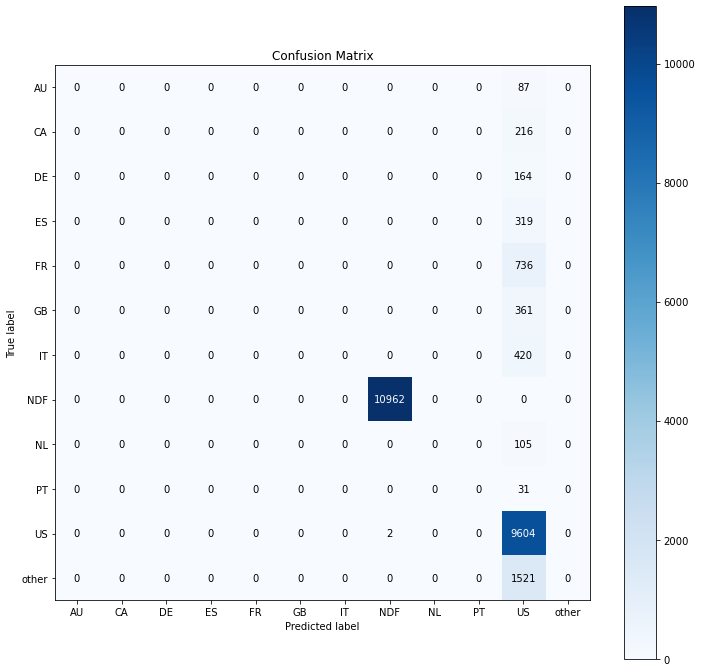

In [142]:
#accuracy
acc_nn = m.accuracy_score(y_test_nn, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

#balanced accuracy
balanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
print('Balanced Accuracy: {}'.format(balanced_acc_nn))

#Kappa metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Accuracy: {}'.format(kappa_nn))

#confusion matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12,12))

### 5.2.3. NN Performance - Cross-Validation

In [143]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_acc_list = []

i = 1

for train_ix, val_ix in kfold.split(X_train, y_train):
    print('Fold Number: {}/{}'.format(i, num_folds))
    
    #get fold
    x_train_fold = X_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = X_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    #target hot-enconding
    ohe = pp.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform(y_train_fold.values.reshape(-1,1)).toarray()
    
    #model definition
    model = ml.Sequential()
    model.add(l.Dense(256, input_dim=X_train.shape[1], activation='relu'))
    model.add(l.Dense(12, activation='softmax'))
    
    #compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #training model
    model.fit(x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0)
    
    #prediction
    pred_nn = model.predict(x_val_fold)
    yhat_nn = ohe.inverse_transform(pred_nn)
    
    #prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape(1, -1)[0]
    
    #metrics
    ##Balanced Accuracy
    baanced_acc_nn = m.balanced_accuracy_score(y_test_nn, yhat_nn)
    balanced_acc_list.append(balanced_acc_nn)
    
    ##Kappa Metrics
    kappa_acc_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
    kappa_acc_list.append(kappa_acc_nn)
    
    i+=1


Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


In [144]:
pickle.dump(balanced_acc_list, open('balanced_acc_list.pkl','wb'))
pickle.dump(kappa_acc_list, open('kappa_acc_list.pkl','wb'))

In [145]:
print('Avg Balanced Accuracy: {} +/- {}'.format(np.round(np.mean(balanced_acc_list),2),
                                                np.round(np.std(balanced_acc_list),4)))
print('Avg Kappa Accuracy: {} +/- {}'.format(np.round(np.mean(kappa_acc_list),2),
                                             np.round(np.std(kappa_acc_list)),4))

Avg Balanced Accuracy: 0.17 +/- 0.0
Avg Kappa Accuracy: 0.72 +/- 0.0
